# Book Recommendation Project

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Read the Users Dataset, Remove NaNs & Explore It

In [2]:
users_df = pd.read_csv('BX-Users.csv', index_col='user_id')
print(users_df.head())

                                   Location   Age
user_id                                          
1                        nyc, new york, usa   NaN
2                 stockton, california, usa  18.0
3           moscow, yukon territory, russia   NaN
4                 porto, v.n.gaia, portugal  17.0
5        farnborough, hants, united kingdom   NaN


In [3]:
# Split Location into city, region, country - add some REGEX cleaning here as well
location_df = users_df['Location'].str.split(', ', n=2, expand=True)
users_df['City'] = location_df[0].str.replace(r'(\/[a-z]{2,})+', '', regex=True).replace('n/a', None).replace('', None)
users_df['Region'] = location_df[1].str.replace(r'(\,$)*', '', regex=True).replace(r'(\/[a-z]{2,})+', '', regex=True).replace('n/a', None).replace('', None)
users_df['Country'] = location_df[2].str.replace(r'(\")*(\.$)*', '', regex=True).replace('n/a', None).replace('', None)
print(users_df.head())

                                   Location   Age         City  \
user_id                                                          
1                        nyc, new york, usa   NaN          nyc   
2                 stockton, california, usa  18.0     stockton   
3           moscow, yukon territory, russia   NaN       moscow   
4                 porto, v.n.gaia, portugal  17.0        porto   
5        farnborough, hants, united kingdom   NaN  farnborough   

                  Region         Country  
user_id                                   
1               new york             usa  
2             california             usa  
3        yukon territory          russia  
4               v.n.gaia        portugal  
5                  hants  united kingdom  


In [4]:
# Clean country a bit
country_good_df = users_df[users_df['Country'].notna()]
country_series = country_good_df['Country']

# fix issues with multiple entries in field separated by comma
country_split = country_series[country_series.str.contains(', ')].str.split(', ', n=1, expand=True)
country_series = pd.concat([country_series,country_split[1]], axis=1, join='outer')
country_series[1] = country_series[1].fillna(country_series['Country'])
country_series.drop(columns=['Country'], inplace=True)

# Join back in to DF
users_df.update(country_series)

In [5]:
# Check how many Country = N/A
country_na_df = users_df[users_df['Country'].isna()]
print(f"Country N/A count: {country_na_df}")

# Get Series based ont he non-N/A values for most frequently occuring countries and each region's most popular country
country_good_df = users_df[users_df['Country'].notna()]
country_counts = country_good_df['Country'].value_counts()
print(country_counts[:12].sum()/country_counts.sum()) # Top 12 countries are 90% of values -- good definition for popularity
region_most_popular_country = country_good_df[['Region','Country']].groupby('Region').apply(lambda x: x.value_counts().sort_values(ascending=False).index[0][1])
print(region_most_popular_country)
city_most_popular_country = country_good_df[['City','Country']].groupby('City').apply(lambda x: x.value_counts().sort_values(ascending=False).index[0][1])
print(city_most_popular_country)

Country N/A count:                        Location   Age           City       Region Country
user_id                                                                  
19                    weston, ,  14.0         weston         None    None
91         toronto/newmarket, ,   NaN        toronto         None    None
312                    lk, jlk,   NaN             lk          jlk    None
318                berlin, n/a,   NaN         berlin         None    None
537          davis, california,   NaN          davis   california    None
...                         ...   ...            ...          ...     ...
278625                savona, ,  36.0         savona         None    None
278652              murrieta, ,   NaN       murrieta         None    None
278698      pasadena, maryland,   NaN       pasadena     maryland    None
278717   mayagüez, puerto rico,  53.0       mayagüez  puerto rico    None
278777   overland park, kansas,   NaN  overland park       kansas    None

[4595 rows x 5 col

In [6]:
# Define a function that replaces missing country values based that row's region column

# Algorithm is if that region value is actually a popular country, make that the country value, else replace with the
# region's top country
def fill_country_na(pop_series, pop_rank, value_series1, value1, value_series2, value2):
    '''
        pop_series - series of occurences of the target value in the good data --> country_counts here
        pop_rank - cutoff for popularity --> going to be 12 here
        value_series - given a value what is the most popular choice for the resultant value --> region_most_popular_country
        value - what we're using to predict --> going to be region here
        
        1 & 2 represent going 2 levels (also using city)
    '''
    pop_series_top = pop_series[:pop_rank]
    # Check if the first value is actually a popular target value
    if value1 in pop_series_top.index:
        return value1
    else:
        # If we can find a region with high popularity, use it
        try:
            if pd.notnull(value1):
                return value_series1[value1]
            # If we find a city with high popularity use that.
            else:
                return value_series2[value2]
        # If we can't find anything we can return unknown
        except KeyError:
            return 'unknown'

In [7]:
country_na_df['Country'] = country_na_df.apply(lambda x: fill_country_na(country_counts, 12, region_most_popular_country, x['Region'], city_most_popular_country, x['City']), axis=1)

print(f"Country Unknowns Before:  {users_df[users_df['Country'].isna()].shape[0]}")
users_df['Country'].update(country_na_df['Country'])
print(f"Country Unknowns After:  {users_df[users_df['Country'].isna()].shape[0] + users_df[users_df['Country']=='unknown'].shape[0]}")

Country Unknowns Before:  4595
Country Unknowns After:  311


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/1047692399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_na_df['Country'] = country_na_df.apply(lambda x: fill_country_na(country_counts, 12, region_most_popular_country, x['Region'], city_most_popular_country, x['City']), axis=1)


In [8]:
# Check unknown regions, and which countries & cities are responsible for the unknown regions, and try to use mode imputation
region_na_df = users_df[users_df['Region'].isna()]
region_good_df = users_df[users_df['Region'].notna()]
print(f"Unknown Region Counts by Country, City:\n\n{region_na_df[['Country','City']].value_counts()}\n\n")

# Get good regions, get most frequently occuring region for country/city pairs, countries
region_good_df = users_df[users_df['Region'].notna()]
country_city_pop_regions = region_good_df.groupby(['Country', 'City'])['Region'].agg(pd.Series.mode)
print(f"Most popular Region based on City, Country:\n\n{country_city_pop_regions}\n\n")

country_pop_regions = region_good_df.groupby('Country')['Region'].agg(pd.Series.mode)
print(f"Most popular Region based on Country:\n\n{country_pop_regions}")

Unknown Region Counts by Country, City:

Country         City       
united kingdom  london         534
singapore       singapore      486
france          paris          339
portugal        lisboa         307
new zealand     auckland       276
                              ... 
luxembourg      luxemburg        1
                mamer            1
                mondercange      1
                mondorf          1
zimbabwe        maseru           1
Length: 4944, dtype: int64


Most popular Region based on City, Country:

Country                          City                                        
 australia, victoria, australia  somers                                                                  victoria
 england, united kingdom         london                                                                      kent
 pasig city., philippines        lot 6 blk. 3 cologne st. mercedes exc. vill.                    brgy. san miguel
&#20013;&#22269;                 shanghai           

In [9]:
# Define a function that replaces missing region values based that row's city & country column

# Algorithm is: 
    # if that city, country has a popular region, make that the region
    # else replace with the most popular region in a given country
    # and failure case is just make the country value the region as well
def fill_region_na(city_country_series, country_series, city, country):
    '''
        city_country_series - most popular region based on city & country in non-NaN region values
        country_series - most popular region based on country alone in non-NaN region values
        city - the city value to match
        country - the country value to match
    '''
    if (country, city) in city_country_series.index:
        return city_country_series[(country, city)]
    elif country in country_series.index:
        return country_series[country]
    else:
        return country

In [10]:
region_na_df['Region'] = region_na_df.apply(lambda x: fill_region_na(country_city_pop_regions, country_pop_regions, x['City'], x['Country']), axis=1)
print(f"Region NA DF after updates:\n\n{region_na_df.head()}")

Region NA DF after updates:

                          Location   Age           City           Region  \
user_id                                                                    
19                       weston, ,  14.0         weston          florida   
31            shanghai, n/a, china  20.0       shanghai         shanghai   
37       san sebastian, n/a, spain  23.0  san sebastian        guipuzcoa   
45            berlin, n/a, germany   NaN         berlin           berlin   
65             n/a, n/a, australia   NaN           None  new south wales   

           Country  
user_id             
19             usa  
31           china  
37           spain  
45         germany  
65       australia  


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/1582207592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_na_df['Region'] = region_na_df.apply(lambda x: fill_region_na(country_city_pop_regions, country_pop_regions, x['City'], x['Country']), axis=1)


In [11]:
# Update the users_df with the replacement region values, check for null region and country values
print(f"Region Unknowns Before:  {users_df[users_df['Region'].isna()].shape[0]}")
users_df.update(region_na_df['Region'])
print(f"Region Unknowns After:  {users_df[users_df['Region'].isna()].shape[0]}")

Region Unknowns Before:  16164
Region Unknowns After:  0


In [12]:
# Check remaining NA values by column
for c in users_df:
    print(f"{c} Nulls:\t{users_df[users_df[c].isna()].shape[0]}")

Location Nulls:	0
Age Nulls:	110762
City Nulls:	560
Region Nulls:	0
Country Nulls:	0


In [13]:
# With so few nulls in the city column, lets just replace a null city value with the region
city_na_df = users_df[users_df['City'].isna()]
city_na_df['City'] = city_na_df['Region']

/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/1086163915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_na_df['City'] = city_na_df['Region']


In [14]:
print(f"City Unknowns Before:  {users_df[users_df['City'].isna()].shape[0]}")
users_df.update(city_na_df['City'])
print(f"City Unknowns After:  {users_df[users_df['City'].isna()].shape[0]}")

City Unknowns Before:  560
City Unknowns After:  0


In [15]:
# Check remaining NA values by column
for c in users_df.columns:
    print(f"{c} Nulls:\t{users_df[users_df[c].isna()].shape[0]}")

Location Nulls:	0
Age Nulls:	110762
City Nulls:	0
Region Nulls:	0
Country Nulls:	0


In [16]:
# We just need to impute the Age column now: quick EDA
country_counts = users_df['Country'].value_counts()
cutoff_value = 500
print(f"Cutoff:\t{cutoff_value}")
print(f"Pct of Users in Countries above Cutoff:\t{country_counts[country_counts>=cutoff_value].sum()/country_counts.sum()}")
print(f"Pct of Countries above Cutoff:\t{country_counts[country_counts>=cutoff_value].count()/country_counts.count()}")

# Plot ages in above cutoff countries, plot all others together
cutoff_countries = country_counts[country_counts>=cutoff_value].index
print(f"\n\nCutoff Countries:\n{cutoff_countries}")
users_df['Country Cutoff'] = users_df.apply(lambda x: x['Country'] if x['Country'] in cutoff_countries else 'below', axis=1)
print(f"\n\nUser Counts:\n{users_df['Country Cutoff'].value_counts()}")

Cutoff:	500
Pct of Users in Countries above Cutoff:	0.9576235933701024
Pct of Countries above Cutoff:	0.025787965616045846


Cutoff Countries:
Index(['usa', 'canada', 'united kingdom', 'germany', 'spain', 'australia',
       'italy', 'france', 'portugal', 'new zealand', 'netherlands',
       'switzerland', 'brazil', 'china', 'sweden', 'india', 'austria',
       'malaysia', 'argentina', 'finland', 'singapore', 'denmark', 'belgium',
       'mexico', 'ireland', 'philippines', 'turkey'],
      dtype='object')


User Counts:
usa               141642
canada             22055
united kingdom     18569
germany            17267
spain              13322
australia          11840
below              11817
italy              11613
france              3517
portugal            3428
new zealand         3152
netherlands         3113
switzerland         1771
brazil              1682
china               1497
sweden              1473
india               1307
austria             1166
malaysia            1122

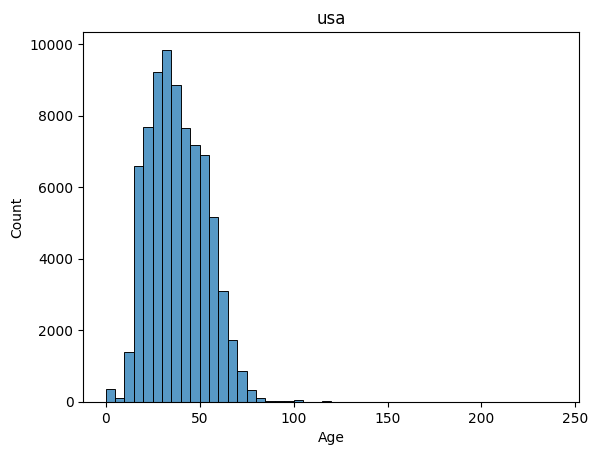

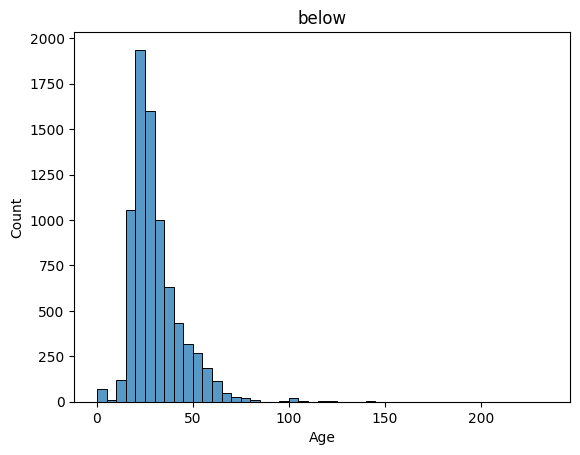

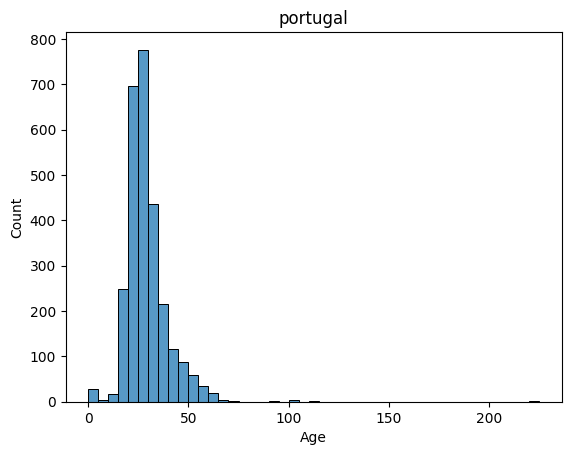

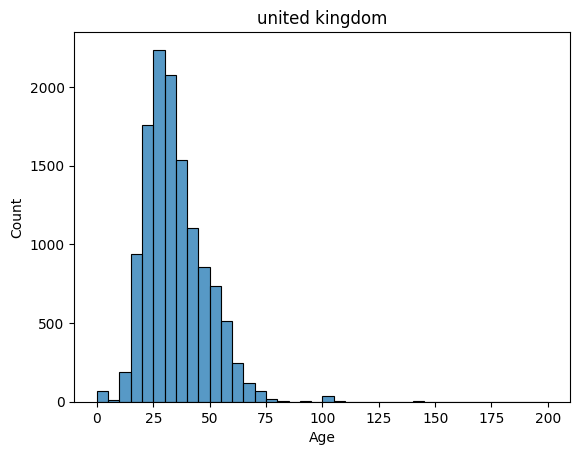

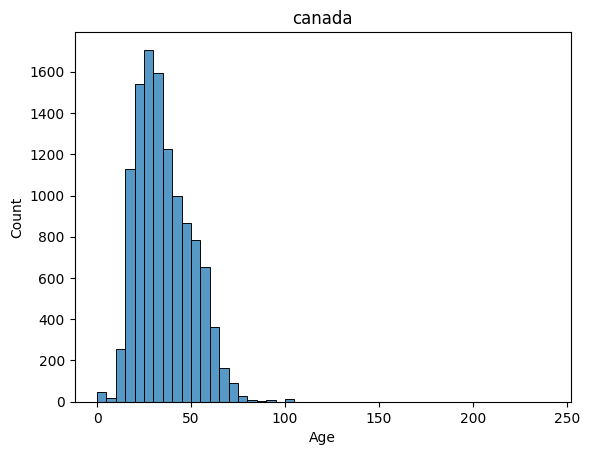

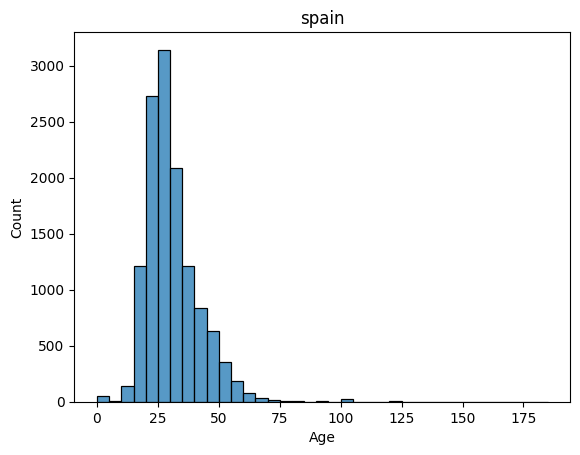

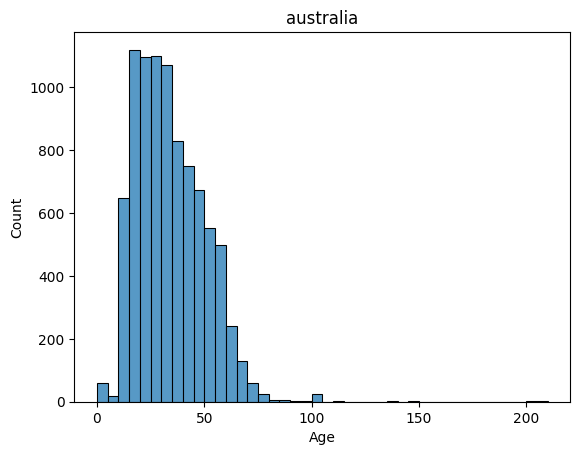

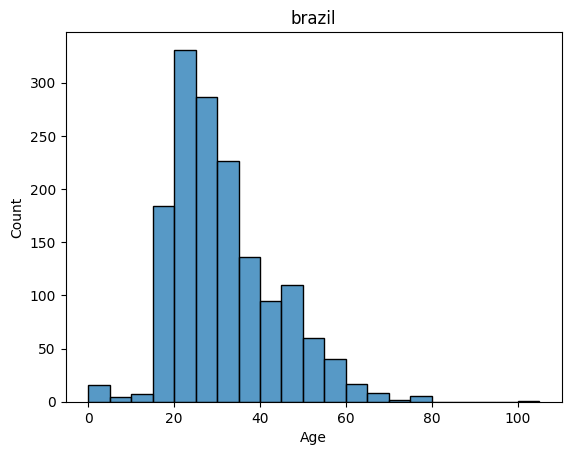

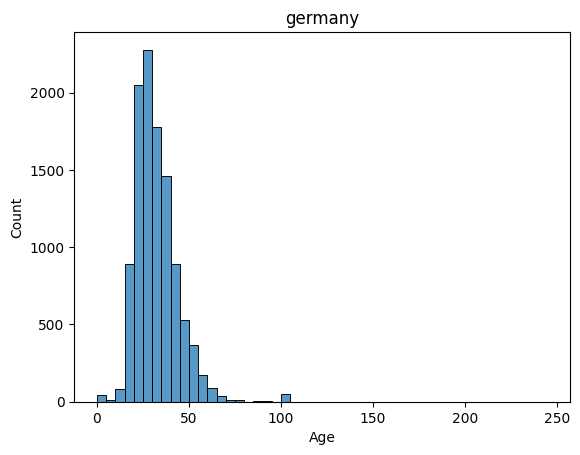

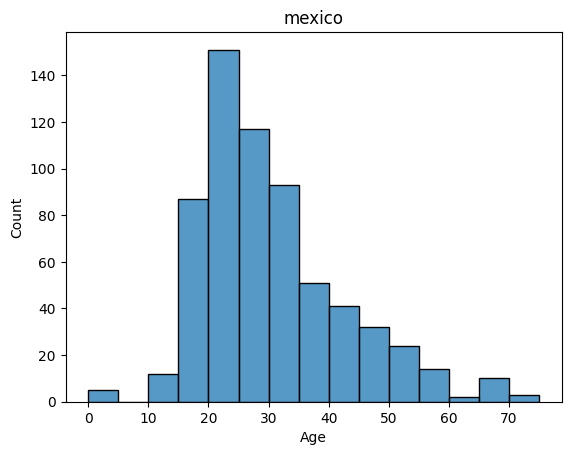

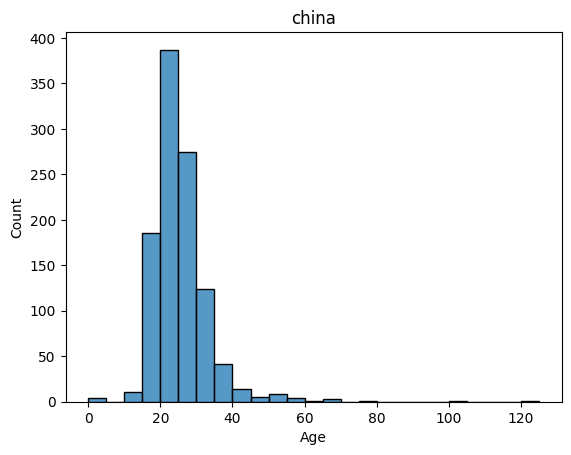

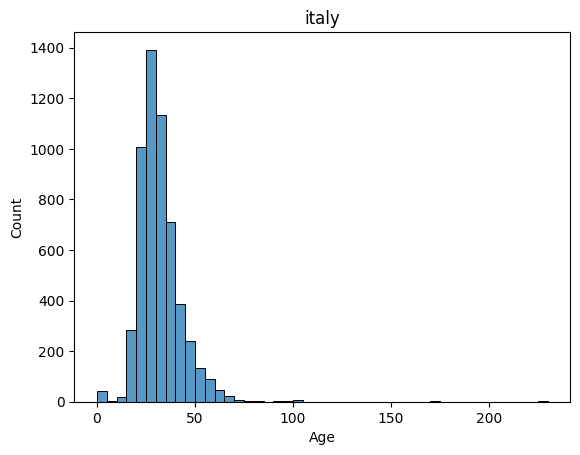

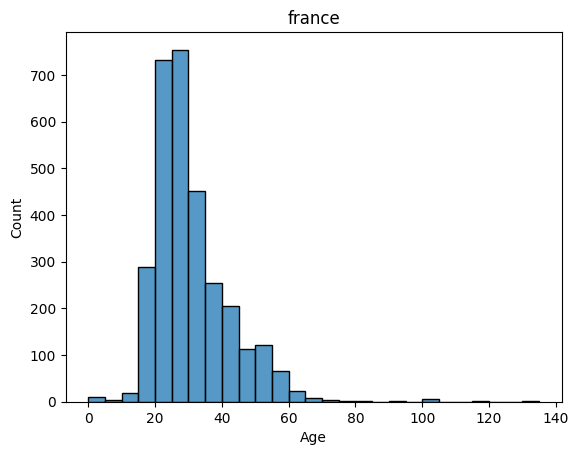

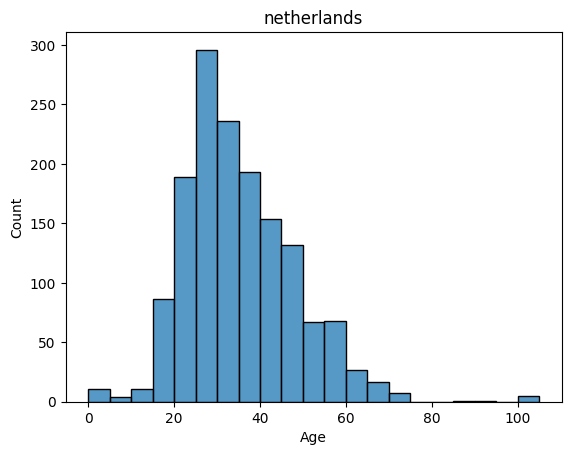

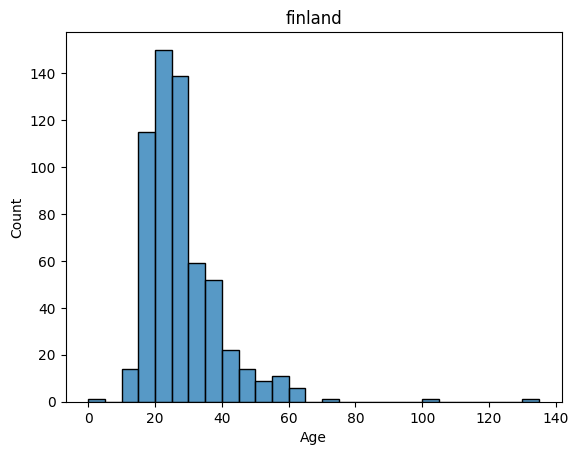

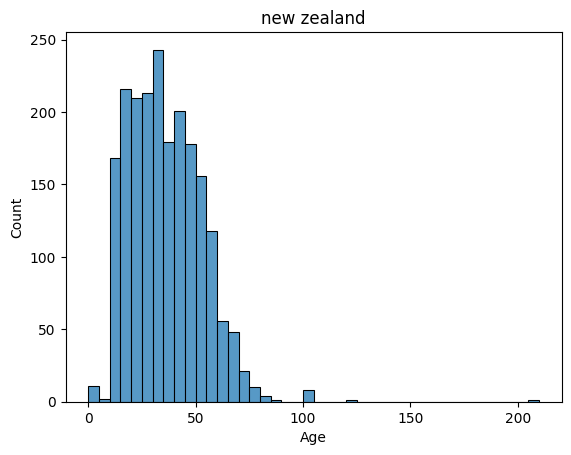

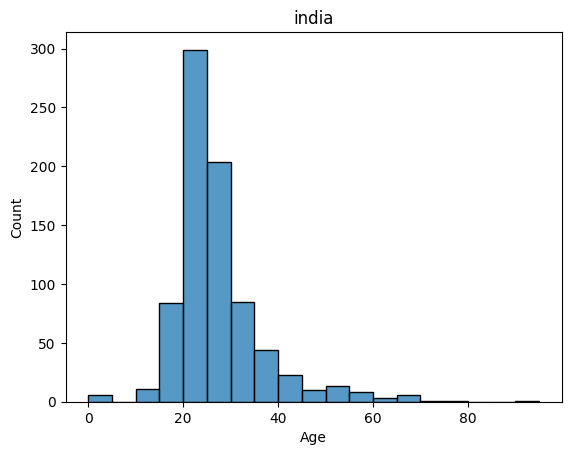

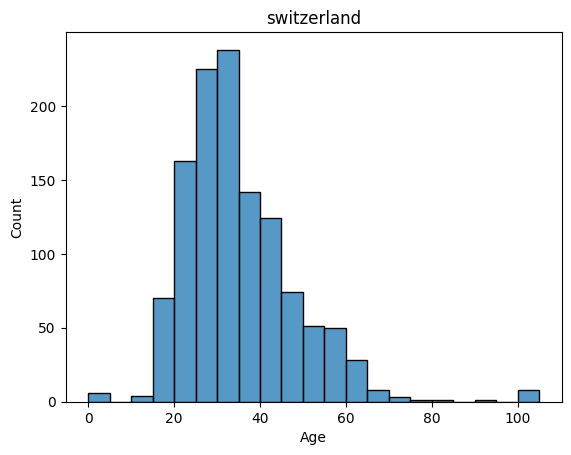

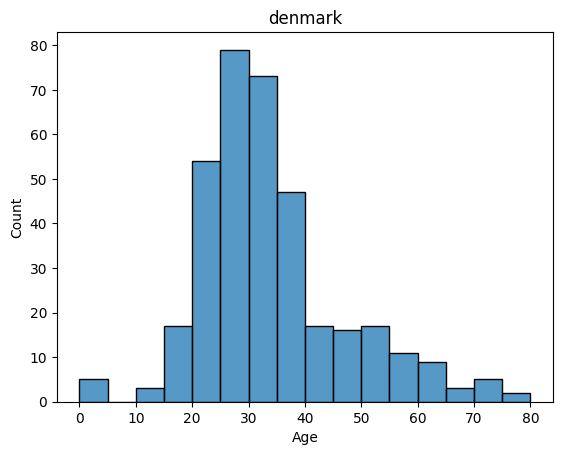

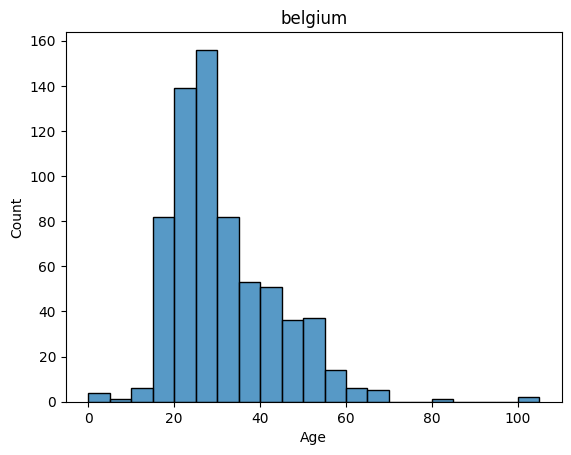

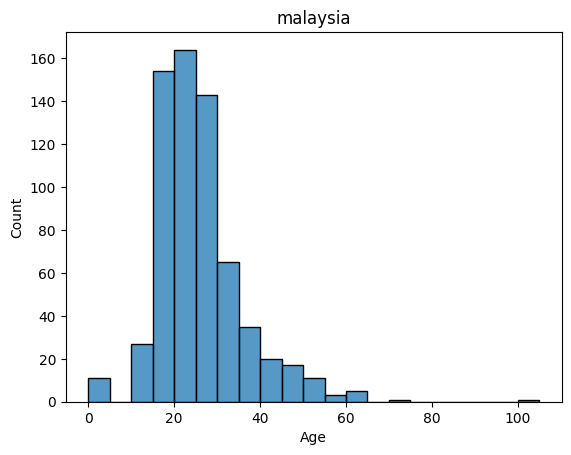

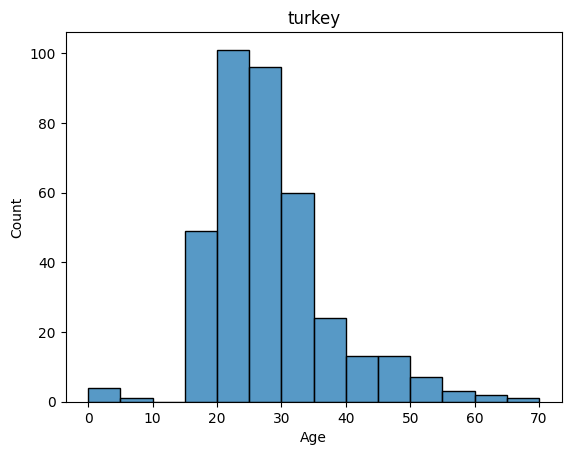

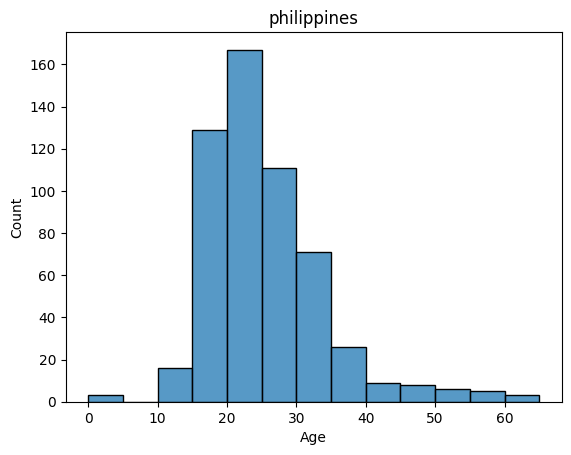

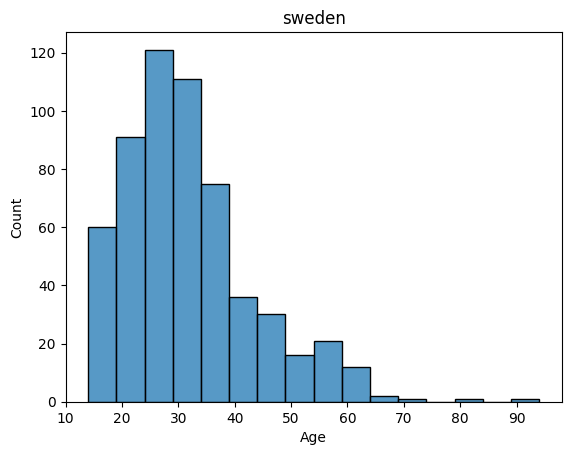

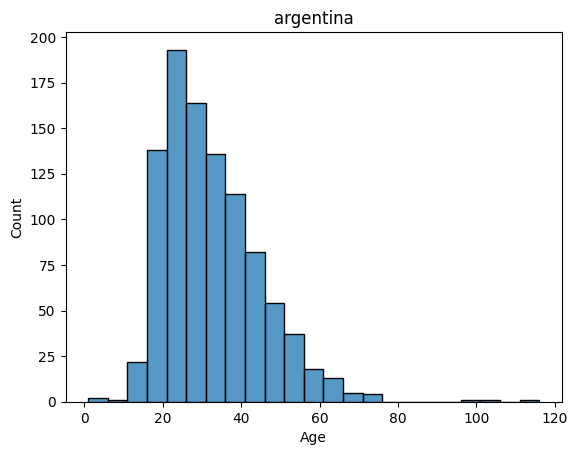

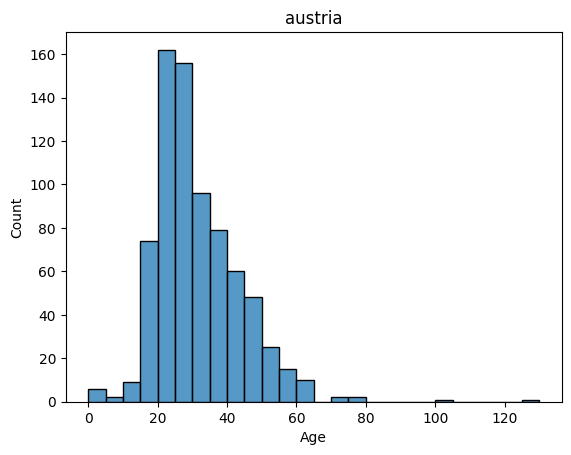

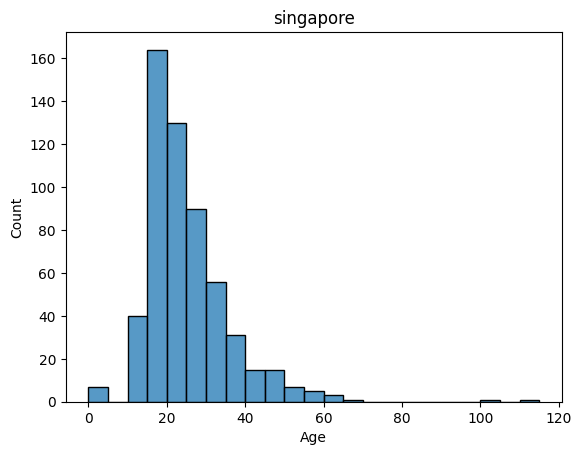

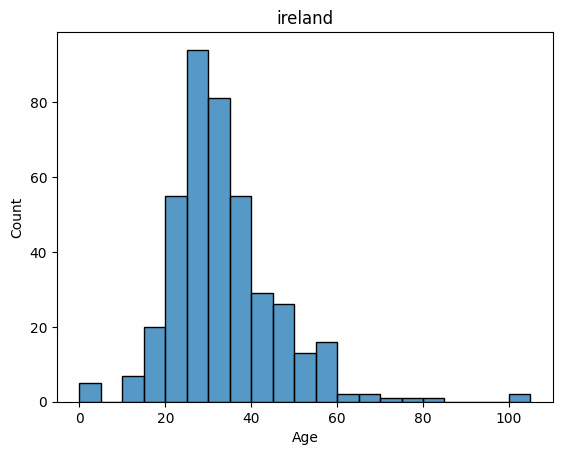

In [17]:
# Create Age histogram by country
for country in users_df['Country Cutoff'].unique():
    plot_data = users_df[users_df['Country Cutoff']==country]
    sns.histplot(plot_data['Age'], binwidth=5).set_title(country)
    plt.show()

In [18]:
# Data not evenly distributed, skewed towards younger --> median imputation by country_cutoff
print(f"\n\nTotal NA Before:\n{users_df[['Age']].isna().value_counts()}")

from sklearn.impute import SimpleImputer

for country in users_df['Country Cutoff'].unique():
    print(f"\n\nImputing:\t\t{country}")
    # partition off specific country
    impute_data = users_df[users_df['Country Cutoff']==country][['Age']].reset_index()
    print(f"NA Count Before:\n{impute_data.isna().value_counts()}")
    
    # build median imputer for country - impute values
    imputer = SimpleImputer(strategy='median')
    imputed = imputer.fit_transform(impute_data)
    df_imputed = pd.DataFrame(imputed, columns=['user_id','Age'])
    impute_data.update(df_imputed)    
    print(f"NA Count After:\n{impute_data[['Age']].isna().value_counts()}")
    
    # Update Users DF with imputed values
    impute_data.set_index(['user_id'], inplace=True)
    users_df.update(impute_data)
    
print(f"\n\nTotal NA After:\n{users_df[['Age']].isna().value_counts()}")



Total NA Before:
Age  
False    168096
True     110762
dtype: int64


Imputing:		usa
NA Count Before:
user_id  Age  
False    False    77163
         True     64479
dtype: int64
NA Count After:
Age  
False    141642
dtype: int64


Imputing:		below
NA Count Before:
user_id  Age  
False    False    7872
         True     3945
dtype: int64
NA Count After:
Age  
False    11817
dtype: int64


Imputing:		portugal
NA Count Before:
user_id  Age  
False    False    2749
         True      679
dtype: int64
NA Count After:
Age  
False    3428
dtype: int64


Imputing:		united kingdom


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

NA Count Before:
user_id  Age  
False    False    12519
         True      6050
dtype: int64
NA Count After:
Age  
False    18569
dtype: int64


Imputing:		canada
NA Count Before:
user_id  Age  
False    False    11501
         True     10554
dtype: int64
NA Count After:
Age  
False    22055
dtype: int64


Imputing:		spain
NA Count Before:
user_id  Age  
False    False    12742
         True       580
dtype: int64
NA Count After:
Age  
False    13322
dtype: int64


Imputing:		australia
NA Count Before:
user_id  Age  
False    False    8915
         True     2925
dtype: int64
NA Count After:
Age  
False    11840
dtype: int64


Imputing:		brazil


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

NA Count Before:
user_id  Age  
False    False    1529
         True      153
dtype: int64
NA Count After:
Age  
False    1682
dtype: int64


Imputing:		germany
NA Count Before:
user_id  Age  
False    False    10755
         True      6512
dtype: int64
NA Count After:
Age  
False    17267
dtype: int64


Imputing:		mexico
NA Count Before:
user_id  Age  
False    False    642
         True     174
dtype: int64
NA Count After:
Age  
False    816
dtype: int64


Imputing:		china
NA Count Before:
user_id  Age  
False    False    1067
         True      430
dtype: int64
NA Count After:
Age  
False    1497
dtype: int64


Imputing:		italy
NA Count Before:
user_id  Age  
False    True     6082
         False    5531
dtype: int64
NA Count After:
Age  
False    11613
dtype: int64


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol



Imputing:		france
NA Count Before:
user_id  Age  
False    False    3064
         True      453
dtype: int64
NA Count After:
Age  
False    3517
dtype: int64


Imputing:		netherlands
NA Count Before:
user_id  Age  
False    True     1608
         False    1505
dtype: int64
NA Count After:
Age  
False    3113
dtype: int64


Imputing:		finland
NA Count Before:
user_id  Age  
False    False    595
         True     358
dtype: int64
NA Count After:
Age  
False    953
dtype: int64


Imputing:		new zealand
NA Count Before:
user_id  Age  
False    False    2045
         True     1107
dtype: int64
NA Count After:
Age  
False    3152
dtype: int64


Imputing:		india
NA Count Before:
user_id  Age  
False    False    799
         True     508
dtype: int64
NA Count After:
Age  
False    1307
dtype: int64


Imputing:		switzerland


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

NA Count Before:
user_id  Age  
False    False    1197
         True      574
dtype: int64
NA Count After:
Age  
False    1771
dtype: int64


Imputing:		denmark
NA Count Before:
user_id  Age  
False    True     510
         False    358
dtype: int64
NA Count After:
Age  
False    868
dtype: int64


Imputing:		belgium
NA Count Before:
user_id  Age  
False    False    675
         True     156
dtype: int64
NA Count After:
Age  
False    831
dtype: int64


Imputing:		malaysia
NA Count Before:
user_id  Age  
False    False    657
         True     465
dtype: int64
NA Count After:
Age  
False    1122
dtype: int64


Imputing:		turkey
NA Count Before:
user_id  Age  
False    False    374
         True     141
dtype: int64
NA Count After:
Age  
False    515
dtype: int64


Imputing:		philippines
NA Count Before:
user_id  Age  
False    False    554
         True     188
dtype: int64
NA Count After:
Age  
False    742
dtype: int64


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol



Imputing:		sweden
NA Count Before:
user_id  Age  
False    True     895
         False    578
dtype: int64
NA Count After:
Age  
False    1473
dtype: int64


Imputing:		argentina
NA Count Before:
user_id  Age  
False    False    986
         True      97
dtype: int64
NA Count After:
Age  
False    1083
dtype: int64


Imputing:		austria
NA Count Before:
user_id  Age  
False    False    748
         True     418
dtype: int64
NA Count After:
Age  
False    1166
dtype: int64


Imputing:		singapore
NA Count Before:
user_id  Age  
False    False    566
         True     368
dtype: int64
NA Count After:
Age  
False    934
dtype: int64


Imputing:		ireland
NA Count Before:
user_id  Age  
False    False    410
         True     353
dtype: int64
NA Count After:
Age  
False    763
dtype: int64


Total NA After:
Age  
False    278858
dtype: int64


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  impute_data.update(df_imputed)
/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/759929208.py:16: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

In [19]:
# drop unneeded columns
users_df.drop(['Location','Country Cutoff'], axis=1, inplace=True)
# Check remaining NA values by column
for c in users_df.columns:
    print(f"{c} Nulls:\t{users_df[users_df[c].isna()].shape[0]}")
# Done with users pruning of Nulls

Age Nulls:	0
City Nulls:	0
Region Nulls:	0
Country Nulls:	0


## Read the Books Dataset, Remove NaNs & Explore It

In [20]:
# Import books data
books_df = pd.read_csv('BX-Books.csv')
# print(books_df)
# print('\n\n')
for c in books_df.columns:
    print(f"{c} Nulls:\t{books_df[books_df[c].isna()].shape[0]}\tDType:\t{books_df[c].dtype}")

isbn Nulls:	0	DType:	object
book_title Nulls:	0	DType:	object
book_author Nulls:	1	DType:	object
year_of_publication Nulls:	0	DType:	object
publisher Nulls:	2	DType:	object


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/324359063.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv('BX-Books.csv')


In [21]:
# There's only one missing author and 2 missing publishers... 
# Replace the nulls with 'none'
books_df.fillna('None', inplace=True)
for c in books_df.columns:
    print(f"{c} Nulls:\t{books_df[books_df[c].isna()].shape[0]}")

isbn Nulls:	0
book_title Nulls:	0
book_author Nulls:	0
year_of_publication Nulls:	0
publisher Nulls:	0


### Convert ISBN & Year to numbers, make ISBN the index

In [22]:
# Convert year values to numerics
# need to find values that cannot be converted to numeric first
def catch_non_num(value):
    '''
        returns True if the value is not convertible to numeric
    '''
    try:
        value = pd.to_numeric(value)
    except:
        return True
#     if value == 0:
#         return True
    return False

books_df['non_num_years'] = books_df.apply(lambda x: catch_non_num(x['year_of_publication']), axis=1)
non_num_years = books_df[books_df['non_num_years'] == True]
# non_num_years.to_csv("non_num_years.csv")

In [23]:
# Returns 23 rows that were messed up based on web scrape formatting
# Issues are:
#     1: There were multiple authors separated by a comma, so CSV split the author into the year row
#         --> if publisher is numeric, make the year the author, and make the publisher the year, and make publisher None
#     2: The Author was put alongside the Title with a semicolon, so year is in the author slot, and publisher is in the year slot
#         --> if author is numeric, everything after the semi colon (minus the last ") in the title is the author, the author is the year, and the year is the publisher
#     3: There's one more that has multiple spots taken up for title, with an author in the publisher
#         --> else make the publisher the author, the year 0, and the publisher none

# can loop over rows because of how small the data set is
for row in non_num_years.itertuples():
    index = row[0]
    book_title = row[2]
    book_author = row[3]
    year_of_publication = row[4]
    publisher = row[5]

    if publisher.isnumeric():
        non_num_years.at[index, 'book_author'] = year_of_publication
        non_num_years.at[index, 'year_of_publication'] = publisher
        non_num_years.at[index, 'publisher'] = 'None'
    elif book_author.isnumeric():
        new_author = book_title.split(';')[-1][:-1]
        non_num_years.at[index, 'book_author'] = new_author
        non_num_years.at[index, 'year_of_publication'] = book_author
        non_num_years.at[index, 'publisher'] = year_of_publication
    else:
        non_num_years.at[index, 'book_author'] = publisher
        non_num_years.at[index, 'year_of_publication'] = 0
        non_num_years.at[index, 'publisher'] = 'None'
        
# write to CSV to check
# non_num_years.to_csv("non_num_years_fixed.csv")


In [24]:
# write to books_df and double_check
books_df.update(non_num_years[['book_title','book_author','year_of_publication','publisher']])
books_df['non_num_years'] = books_df.apply(lambda x: catch_non_num(x['year_of_publication']), axis=1)
non_num_years_check = books_df[books_df['non_num_years'] == True]
print(f"Remaining Non-Numeric Years:\t{non_num_years_check.shape[0]}\n\n")

# drop helper columns, and convert year to numeric
books_df.drop(['non_num_years'], axis=1, inplace=True)
books_df['year_of_publication'] = books_df['year_of_publication'].apply(pd.to_numeric)
print(books_df.dtypes)

Remaining Non-Numeric Years:	0


isbn                   object
book_title             object
book_author            object
year_of_publication     int64
publisher              object
dtype: object


### Drop Duplicate ISBNs and convert to numeric

In [25]:
# Convert trailing 'X' to '10' for ISBN conversion
# There's another format in the column that I can't identify
# going to convert to numeric by converting each character in the string to it's ord value
# Also because we need to keep leading zeros, if hte first number in the resulting ISBN is zero we'll add a 1 to the beginning

import re

def isbn_format_converter(isbn):
    # REGEX replace of trailing X
    isbn = re.sub(r'(x|X)$','10',isbn)
    
    # Loop over characters looking to replace characters
    replace_isbn = ''
    for character in isbn:
        if character.isnumeric():
            replace_isbn = replace_isbn + character
        else:
            replace_isbn = replace_isbn + str(ord(character))
            non_numeric = True
    
    # Keep leading 0's
    if replace_isbn[0] == '0':
        return '1' + replace_isbn
    else:
        return replace_isbn

In [26]:
# apply function and check for ability to convert to numeric
books_df['isbn'] = books_df.apply(lambda x: isbn_format_converter(x['isbn']), axis=1)
books_df['ISBN Numeric'] = books_df['isbn'].str.isnumeric()
print(f"Count of remaining non-numeric ISBN:\t{books_df[books_df['ISBN Numeric']==False].shape[0]}\n\n")
# finally convert to Numeric
books_df['isbn'] = pd.to_numeric(books_df['isbn'])
books_df.drop(['ISBN Numeric'], axis=1, inplace=True)
print(books_df.dtypes)

Count of remaining non-numeric ISBN:	0


isbn                    int64
book_title             object
book_author            object
year_of_publication     int64
publisher              object
dtype: object


In [27]:
# Check if the actual books are the same (double entered) or if the books are different (actual difference in case)
isbn_counts = books_df['isbn'].value_counts()
books_df = books_df.merge(isbn_counts, how='left', left_on=['isbn'], right_index=True, suffixes=('','_count'))
non_dupe_df = books_df[books_df['isbn_count']==1] # save non-duplicate ISBNs
dupe_df = books_df[books_df['isbn_count']>1].sort_values(['isbn'])
print(f"Rows in potential dupe DF:\t{dupe_df.shape[0]}")
# dupe_df.to_csv("dupe_check1.csv")
dupe_df.drop_duplicates(subset=None, keep="first", inplace=True)
print(f"Unique Rows in dupe DF:\t{dupe_df.shape[0]}\n\n")
# dupe_df.to_csv("dupe_check2.csv")

Rows in potential dupe DF:	628
Unique Rows in dupe DF:	315




In [28]:
# Still have some duplicates
isbn_counts = dupe_df['isbn'].value_counts()
dupe_df = dupe_df.merge(isbn_counts, how='left', left_on=['isbn'], right_index=True, suffixes=('','_count2'))
dupe_df2 = dupe_df[dupe_df['isbn_count2'] == 2] # keep duplicates in separate DF
dupe_df = dupe_df[dupe_df['isbn_count2'] == 1] # remove any potential duplicates
print(f"Remaining Dupes:\n{dupe_df2}")

Remaining Dupes:
                isbn                              book_title   book_author  \
16203   105151362810  Key of Light (Key Trilogy (Paperback))  Nora Roberts   
213846  105151362810                            Key of Light  Nora Roberts   

        year_of_publication   publisher  isbn_count  isbn_count2  
16203                  2003  Jove Books           2            2  
213846                 2003  Jove Books           2            2  


In [29]:
# Let's keep the top value from the only duplicate ISBN
dupe_df2 = dupe_df2.head(1)

# drop helper columns
dupe_df2.drop(['isbn_count','isbn_count2'], axis=1, inplace=True)
dupe_df.drop(['isbn_count','isbn_count2'], axis=1, inplace=True)
non_dupe_df.drop(['isbn_count'], axis=1, inplace=True)

# print the 3 DFs containing all the non-duplicate books
# print(dupe_df2)
# print(dupe_df)
# print(non_dupe_df)

# concat and check for dupes again
books_df = pd.concat([non_dupe_df, dupe_df, dupe_df2])
isbn_counts = books_df['isbn'].value_counts()
print(f"Should return true if no duplicates are left over:\t{isbn_counts.max()==1}")

Should return true if no duplicates are left over:	True


/var/folders/r7/dtjny68152z02rjhb55rxv300000gn/T/ipykernel_28725/1259395050.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_dupe_df.drop(['isbn_count'], axis=1, inplace=True)


In [30]:
# final check on nulls and datatypes
for c in books_df.columns:
    print(f"{c}\n\tNulls:\t{books_df[books_df[c].isna()].shape[0]}\n\tDType:\t{books_df[c].dtype}\n\n")
    
# set isbn to the index and move on
books_df.set_index(['isbn'], inplace=True)
print(books_df.head())

isbn
	Nulls:	0
	DType:	int64


book_title
	Nulls:	0
	DType:	object


book_author
	Nulls:	0
	DType:	object


year_of_publication
	Nulls:	0
	DType:	int64


publisher
	Nulls:	0
	DType:	object


                                                  book_title  \
isbn                                                           
195153448                                Classical Mythology   
2005018                                         Clara Callan   
60973129                                Decision in Normandy   
374157065  Flu: The Story of the Great Influenza Pandemic...   
393045218                             The Mummies of Urumchi   

                    book_author  year_of_publication  \
isbn                                                   
195153448    Mark P. O. Morford                 2002   
2005018    Richard Bruce Wright                 2001   
60973129           Carlo D'Este                 1991   
374157065      Gina Bari Kolata                 1999   
393045218       E. J. W.

## Read the data where ratings are given by users

## Convert ISBN variables to numeric numbers in the correct order

## Convert the user_id variable to numeric numbers in the correct order

In [31]:
# Import ratings data
ratings_df = pd.read_csv('BX-Book-Ratings.csv')

# Convert ISBN similarly to how we did in the Books dataset
ratings_df['isbn'] = ratings_df.apply(lambda x: isbn_format_converter(x['isbn']), axis=1)
ratings_df['isbn'] = pd.to_numeric(ratings_df['isbn'], errors='coerce')
# ratings_df['isbn_null'] = ratings_df['isbn'].isna()
# print(ratings_df[ratings_df['isbn_null']==True])

# print nulls and datatypes for columns
print('\n\nRatings Nulls by Column')
for c in ratings_df.columns:
    print(f"{c}\tNulls:\t{ratings_df[ratings_df[c].isna()].shape[0]},\t Datatype:\t{ratings_df[c].dtype}")



Ratings Nulls by Column
user_id	Nulls:	0,	 Datatype:	int64
isbn	Nulls:	0,	 Datatype:	float64
rating	Nulls:	0,	 Datatype:	int64


## Take a quick look at the number of unique users and books

In [32]:
# Check unique users in the users_df compared to the ratings_df
users_df_uniques = users_df.index.value_counts()
ratings_df_unique_users = ratings_df['user_id'].value_counts()

print(f"Users DF Users:\t\tUniques: {users_df_uniques.count()}\tMax Occurences: {users_df_uniques.max()}\tAvg Occurences: {users_df_uniques.mean()}")
print(f"Ratings DF Users:\tUniques: {ratings_df_unique_users.count()}\tMax Occurences: {ratings_df_unique_users.max()}\tAvg Occurences: {ratings_df_unique_users.mean()}")

Users DF Users:		Uniques: 278858	Max Occurences: 1	Avg Occurences: 1.0
Ratings DF Users:	Uniques: 95513	Max Occurences: 13602	Avg Occurences: 10.978348497063227


In [33]:
# Check unique books in the books_df compared to the ratings_df
books_df_uniques = books_df.index.value_counts()
ratings_df_unique_books = ratings_df['isbn'].value_counts()

print(f"Books DF Books:\t\tUniques: {books_df_uniques.count()}\tMax Occurences: {books_df_uniques.max()}\tAvg Occurences: {books_df_uniques.mean()}")
print(f"Ratings DF Books:\tUniques: {ratings_df_unique_books.count()}\tMax Occurences: {ratings_df_unique_books.max()}\tAvg Occurences: {ratings_df_unique_books.mean()}")

Books DF Books:		Uniques: 271065	Max Occurences: 1	Avg Occurences: 1.0
Ratings DF Books:	Uniques: 321787	Max Occurences: 2264	Avg Occurences: 3.2585996326762734


## Convert both user_id and ISBN to the ordered list, i.e., from 0...n-1

In [34]:
user_id_values = ratings_df['user_id'].unique()
user_id_values = np.sort(user_id_values)
print(f"Sorted User IDs:\n{user_id_values}")
      
isbn_values = ratings_df['isbn'].unique()
isbn_values = np.sort(isbn_values)
print(f"Sorted ISBNs:\n{isbn_values}")

Sorted User IDs:
[     2      7      8 ... 278851 278852 278854]
Sorted ISBNs:
[1.00000000e+01 2.00000000e+01 5.10000000e+01 ... 7.89711411e+28
 6.51141111e+35 7.49711010e+35]


## Re-index the columns to build a matrix

In [35]:
# Creating a pivot table (i.e. a column for each movie) made my computer run out of memory
# Going to represent as a multi-index, and a missing value is a NaN
ratings_matrix = ratings_df.set_index(['user_id','isbn'])
ratings_matrix.sort_index(ascending=True, inplace=True)
print(ratings_matrix)

                      rating
user_id isbn                
2       1.951534e+08       0
7       3.454225e+07       0
8       2.005018e+06       5
        6.097313e+07       0
        3.741571e+08       0
...                      ...
278854  5.150871e+08       0
        5.532757e+08       6
        5.535786e+08       0
        5.535796e+08       8
        1.042516e+11       7

[1048575 rows x 1 columns]


## Split your data into two sets (training and testing)
- Going to do test/train for first iteration
- Going to do Cross-Validation with GridSearc later for better results and model tuning

In [36]:
# Use the surprise module for cross-validation and algorithm implementation
from surprise import Reader, Dataset, KNNBasic, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split, KFold

# Define Reader and Dataset objects to use with surprise module
ratings_max = ratings_matrix['rating'].max()
ratings_min = ratings_matrix['rating'].min()
reader = Reader(rating_scale=(ratings_min,ratings_max))
ratings_data = Dataset.load_from_df(ratings_df[['user_id','isbn','rating']], reader)

In [37]:
# Define KNN Algo with pre-defined parameters
sim_options = {
    'name': 'pearson_baseline',  # User pearson similarity metric
    'user_based': False,         # Compute similarites between movies rather than users
}
algoKNN = KNNBasic(sim_options=sim_options)

# KNN was using too much memory -- adding SVD
algoSVD = SVD()

In [38]:
# Split data into train and test
trainset, testset = train_test_split(ratings_data, test_size=0.25)

# Fit the algorithm to the data
algoSVD.fit(trainset)
predsSVD = algoSVD.test(testset)

# Print RMSE of the model
rmse_val = accuracy.rmse(predsSVD, verbose=True)
print(f"\n\nRMSE Pct of Total Ratings Range:\t{rmse_val/(ratings_max-ratings_min)*100}%")

RMSE: 3.4942


RMSE Pct of Total Ratings Range:	34.94240356769844%


In [40]:
# Cross-Validate with 5 folds, and print RMSE
kf = KFold(n_splits=5)

# Create algos
algoKNN = KNNBasic(sim_options=sim_options)
algoSVD = SVD()

# iterator vars
rmse_vals = []
use_KNN = False # Still too large for my machine although I'm sure it'd perform better
if use_KNN:
    algo = algoKNN
else:
    algo = algoSVD
    
for train, test in kf.split(ratings_data):
    algo.fit(train)
    preds = algo.test(test)
    rmse_val = accuracy.rmse(preds, verbose=True)
    rmse_vals.append(rmse_val)
    
print(f"\n\nAvg RMSE:\t{sum(rmse_vals)/len(rmse_vals)}")

RMSE: 3.4918
RMSE: 3.4966
RMSE: 3.4951
RMSE: 3.4923
RMSE: 3.4882


Avg RMSE:	3.4928043900843497


In [43]:
# Use GridSearch to optimize model
from surprise.model_selection import GridSearchCV

param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid=param_grid, measures=['rmse'], cv=5)

# Fit the candidates
gs.fit(ratings_data)

# Print Best Score
print(gs.best_score["rmse"])

# Print Params for Best Score
print(gs.best_params["rmse"])

3.4310072491679406
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [45]:
# Save the model with the best performance
best_model = gs.best_estimator['rmse']

# I would ahve liked to use KNN, but I coulodn't get my local or the lab instance to support enough memory for the operations